In [1]:
%%capture
import struct 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
import pandas as pd
from helpers import read_echogram

class EchoGram:
    def __init__(self, filename, channels=None, depthline=False):
        """data is a list of dictionaries
        echo is an nd array (2D=only rows and columns)
        """
        self.filename = filename
        self.data, self.echo = self.test_overlay_wb_echo(filename, channels, depthline)
        
    def test_overlay_wb_echo(self, filename, channels=None, depthline=False):
        # Load sounding data and echogram.
        data, echo = read_echogram(filename, channels)

        ## Calculate sampling rate, using assumption that y-axis is in depth (ft)
        ## - not actually used in this function but given here as an illustration.
        # time1 = np.array([i["time1"] for i in data])
        # dz = time1[1:] - time1[:-1]
        if depthline:
            ## Calculate the water depth in y-axis samples
            wb = np.array([i["water_depth"] for i in data])
            lower_limit = np.array([i["lower_limit"] for i in data])
            wb_s =  wb * echo.shape[0] / lower_limit

        fig, axes = plt.subplots()
        axes.imshow(echo, aspect='auto')
        if depthline:
            axes.plot([i["frame_index"] for i in data],
                        wb_s, linewidth=2, color="red")
        fig.show()
        #fig.savefig('sss.png', dpi=fig.dpi)
        return data, echo

### Datasets:
- './log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2'    
- './log-data-lowrance/Sonar_2021-10-16_13.29.30.sl2'
- './log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.21.09.sl2'
- './log-data-lowrance/Sonar_2021-10-16_14.38.24.sl2'

### Channel (sonar sensor type)
- 0 = Primary (Traditional Sonar)
- 1 = Secondary (Traditional Sonar)
- 2 = DSI (Downscan Imaging)
- 3 = Sidescan Left
- 4 = Sidescan Right
- 5 = Sidescan (Composite)
Another other value is treated as Invalid.

## File:Sonar_2021-10-16_12.53.38 Speed=4mph

In [2]:
#echogram1 = EchoGram('./log-data-lowrance/Sonar_2021-10-16_12.53.38.sl2', channels=[5])

## File:Sonar_2021-10-16_13.29.36 Speed=6mph

  0%|          | 0.00/327M [00:00<?, ?B/s]

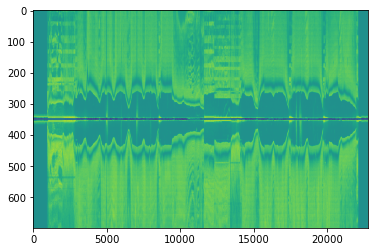

In [3]:
echogram6mph = EchoGram('./log-data-lowrance/Sonar_2021-10-16_13.29.36.sl2', channels=[5])

In [4]:
vmin = min(echogram6mph.echo.flat)
vmax = max(echogram6mph.echo.flat)
print("echo shape:",echogram6mph.echo.shape)
print("type(data):",type(echogram6mph.data))
print("length:",len(echogram6mph.data))
print("min intensity=",vmin)
print("max intensity=",vmax)

echo shape: (700, 22784)
type(data): <class 'list'>
length: 22784
min intensity= -2142878100.0
max intensity= 2141233300.0


length:  22784
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 3.3554432e+07 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  5.0397440e+07 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.7174400e+07
  2.0000000e+00 3.3554432e+07]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.5900000e+02
  0.0000000e+00 6.6564000e+04]]


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 432x288 with 0 Axes>

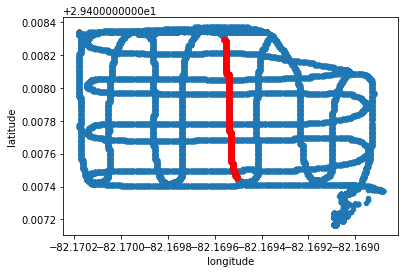

In [5]:
df2 = pd.DataFrame(echogram6mph.data)
print("length: ",len(df2['longitude']))
print(echogram6mph.echo)
fig = plt.figure()
ax2 = df2.plot.scatter(x="longitude", y="latitude")
df2.loc[5600:6400,:].plot.scatter(x="longitude", y="latitude", c='red', ax=ax2)

In [6]:
#df2.info()

In [7]:
def lat_lon_to_meters(lon, lat):
        """ Convert longitude and latitude to global X and Y coordinates in meters
        """
        # Using Spherical Pseudo-Mercator projection
        # https://wiki.openstreetmap.org/wiki/Mercator
        R =  6378137.0
        Y = np.log(np.tan(np.pi / 4 + np.radians(lat) / 2)) * R
        X = np.radians(lon) * R
        X = X - X[0]
        Y = Y - Y[0]
        return X, Y
    
def get_distance(x,y):
    """calculates the euclidean distance for a sequence of points in the x and y coordinate
    """
    dx = np.diff(x)
    dy = np.diff(y)
    return np.add.accumulate(np.sqrt(dx**2 + dy**2))

X, Y = lat_lon_to_meters(df2["longitude"].to_numpy(), df2["latitude"].to_numpy())
df2["X_m"] = X
df2["Y_m"] = Y
distance = get_distance(X, Y)
distance = np.append(distance, distance[-1])
df2["distance_m"] = distance

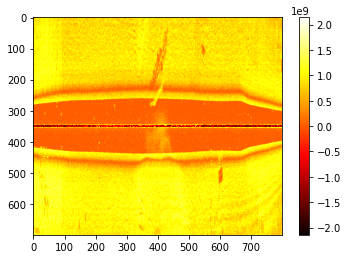

In [8]:
plt.imshow(echogram6mph.echo[:,5600:6400], cmap='hot', vmin=vmin, vmax=vmax)
plt.colorbar()

# Point Cloud Generation

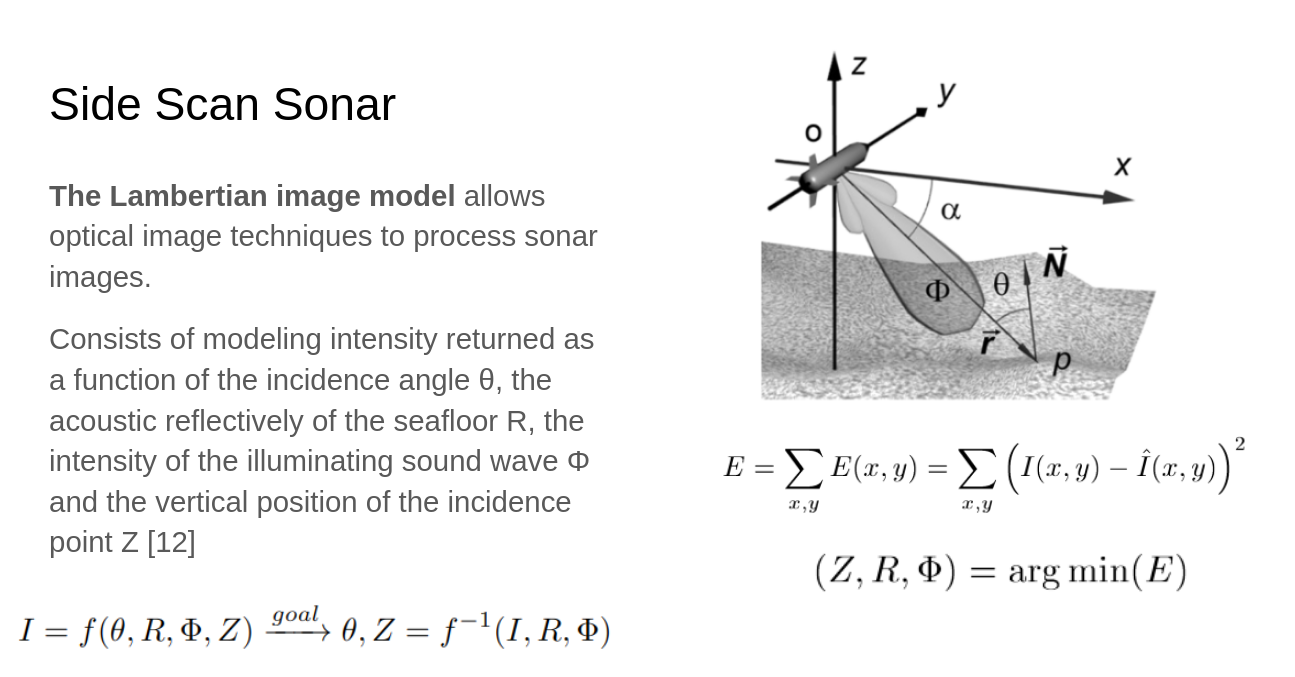

sss shape:  (700, 800)


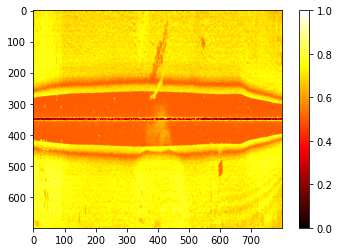

In [9]:
## Scale intensity values using min max normalization
sss = plt.imread('./images/sss.png') # image file, ndarray, with shape: (288, 432, 4)
sss_intensity_raw = echogram6mph.echo[:, 5600:6400]
rows, columns = sss_intensity_raw.shape  # 700
print("sss shape: ", sss_intensity_raw.shape)
vmin = np.min(sss_intensity_raw)
vmax = np.max(sss_intensity_raw)
sss_intensity = (sss_intensity_raw - vmin) / (vmax - vmin)
plt.imshow(sss_intensity, cmap='hot')
plt.colorbar()

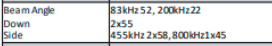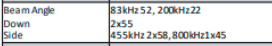60 to 85 degrees  Source:https://www.sportfishingmag.com/how-imaging-sonar-helps-you-find-fish/
<div>
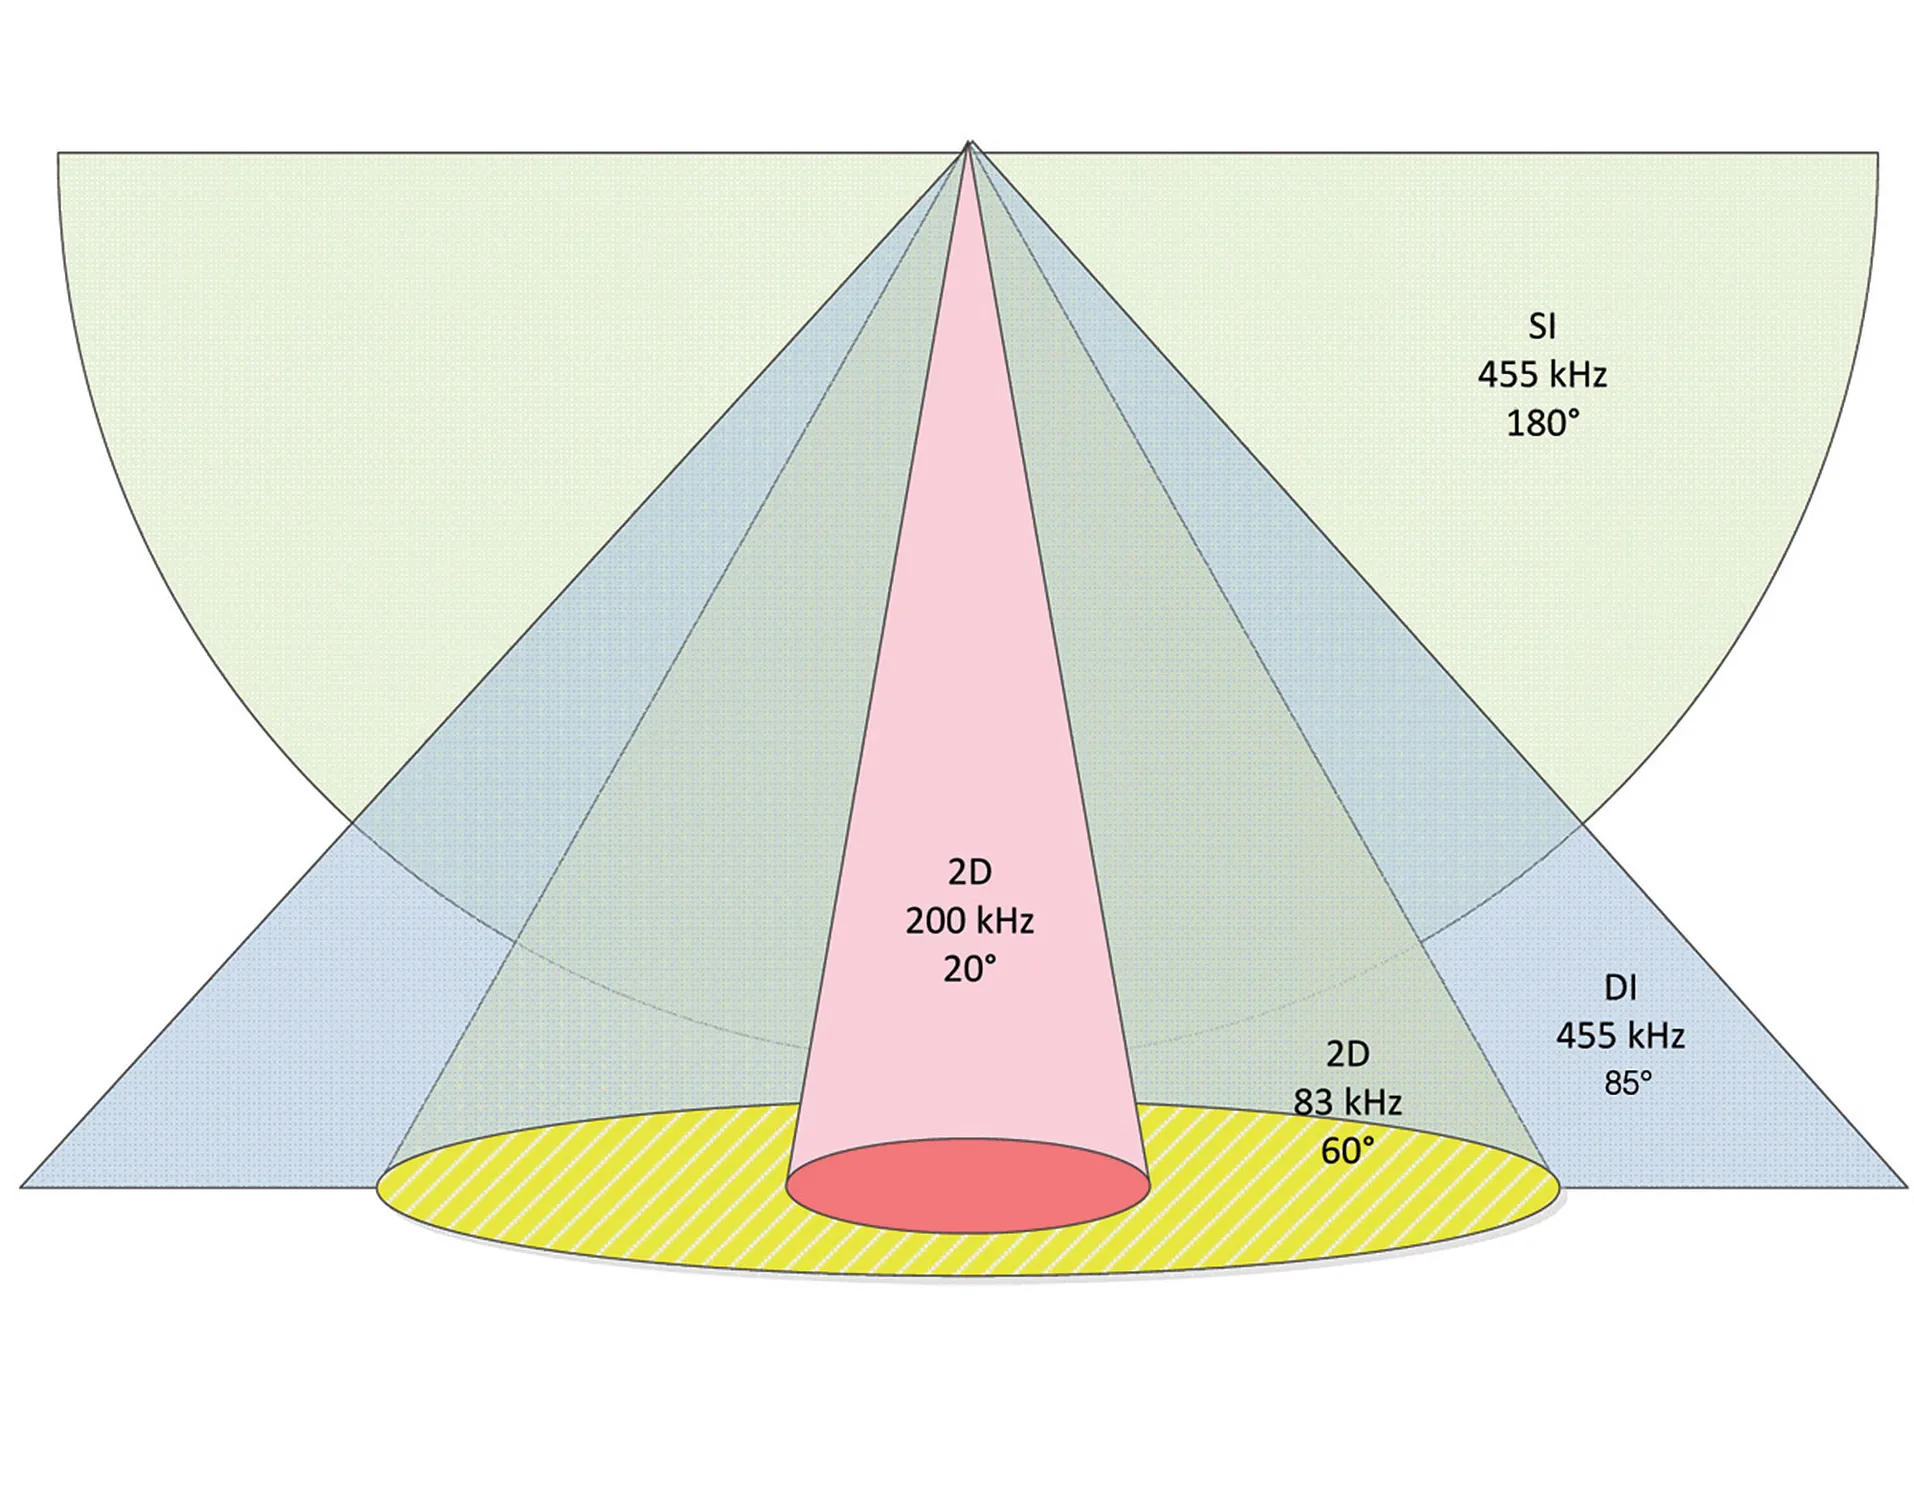
</div>

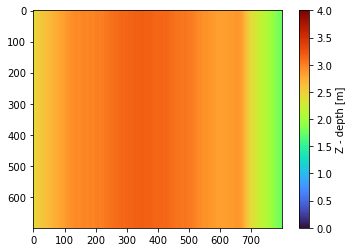

In [10]:
## Initialize values

#df2 = pd.DataFrame(echogram6mph.data)
## Z
depth_m = df2.loc[5600:6400,:]['water_depth_m'].to_numpy()  # ndarray shape: (801,)
depth_m = depth_m[0:-1] # eliminate last column to agree with sonar shape
Z0 = np.tile(depth_m, (rows, 1))  # grid of depth values repeated in per row in meters (TO REPEAT AN ARRAY AS A ROW)
plt.imshow(Z0, cmap='turbo', vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Z - depth [m]')
## X
x_m = df2.loc[5600:6400,:]['distance_m'].to_numpy()[0:-1]
x_m = x_m - x_m[0]
x_m = np.tile(x_m, (rows, 1))


Text(0, 0.5, 'x [m]')

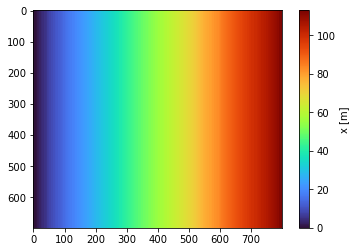

In [11]:
plt.imshow(x_m, cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('x [m]')

### Angles:

<div>
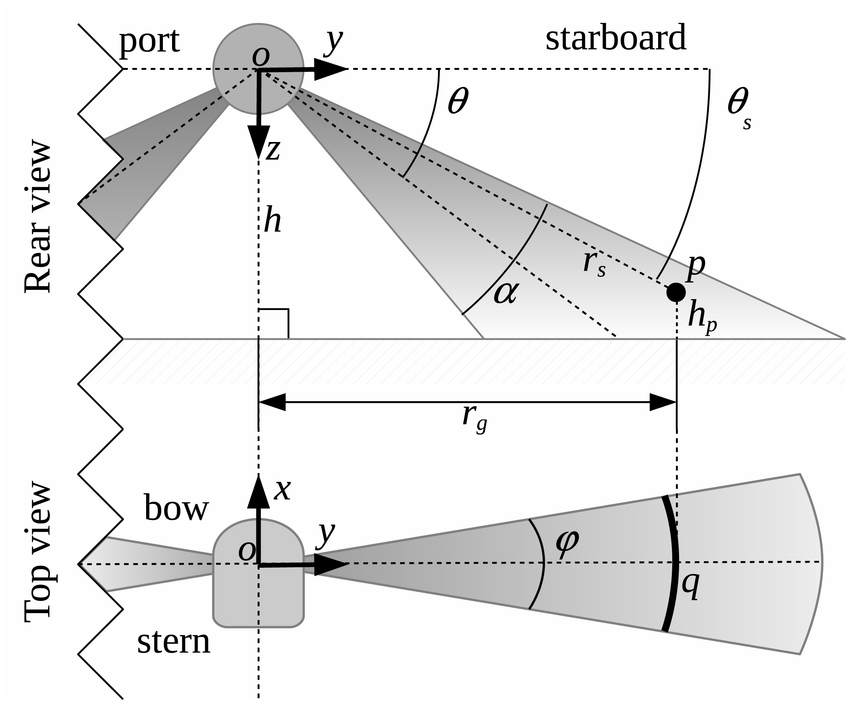
</div>

Text(0, 0.5, 'angles [rad]')

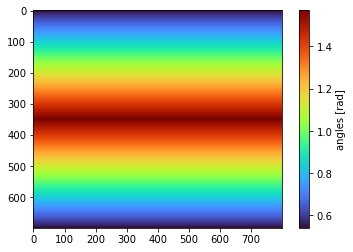

In [12]:
# Fixed Coordinate system: x - front, y - right, z - down 
alpha = 58 # from lowrance
theta = 60
alpha_max = theta + alpha/2
alpha_min = theta - alpha/2
angles_rad = np.radians(np.concatenate((np.linspace(alpha_min,90,int(rows/2)),np.linspace(90,alpha_min,int(rows/2))))) # array of angles starting at zero, 90deg at the middle and then zero
angles_rad = np.transpose([angles_rad] * columns)  # TO REPEAT AN ARRAY AS A COLUMN

## Y
y_m = np.zeros((rows, columns))
y_m = np.divide(Z0, np.tan(angles_rad))
y_m[0:350,:] = y_m[0:350]*(-1)
plt.imshow(angles_rad, cmap='turbo', interpolation='nearest')
cbar = plt.colorbar()
cbar.ax.set_ylabel('angles [rad]')


Text(0, 0.5, 'y coord [m]')

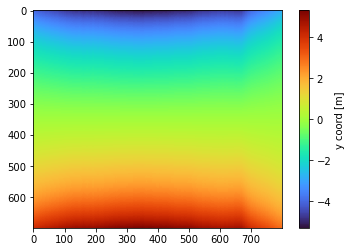

In [13]:
plt.imshow(y_m, cmap='turbo', interpolation='nearest')
cbar = plt.colorbar()
cbar.ax.set_ylabel('y coord [m]')

Text(0.5, 0, 'Data points')

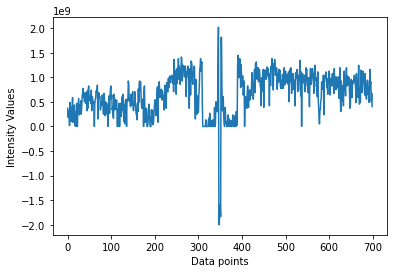

In [14]:
# Example of a single strip os sss data
fig, ax = plt.subplots()
plt.plot(range(700),echogram6mph.echo[:,15103])
ax.set_ylabel("Intensity Values")
ax.set_xlabel("Data points")

## Coiras, et al.Replication

Text(0, 0.5, 'Phi intitialized')

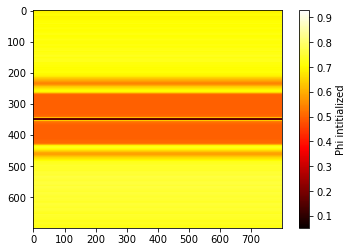

In [15]:
lambda_cons = 0.25
# Reflectivity
R0 = np.ones((rows, columns))*0.9  # reflectivity (typically from 0 to 1)
dy = np.diff(y_m, axis=0)
dy = np.concatenate((dy, dy[-1, :].reshape(1, columns)), axis=0) # make dy to have same shape as y_m
I_max0 = np.divide(-Z0 + np.divide(x_m**2*(1+dy*Z0)**2,-Z0), np.sqrt(x_m**2+Z0**2)*(1+(dy*Z0)**2 + np.divide(x_m**2*(1+(dy*Z0)**2),-Z0**2)))
K_reflec0 = np.divide(1, I_max0) 

# Beam Profile
Phi0 = np.copy(sss_intensity)
for ii in np.arange(rows):
        Phi0[ii, :] = np.median(Phi0[ii, :])  # Phi(x,y)=Median{Phi(x0,y0)|alpha(x0,y0)=alpha(x,y)}        
plt.imshow(Phi0, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Phi intitialized')

Imax max value:  4.403681793263987
Imax min value:  -3.7157449617416196
Reflectivity max value:  64.72827377203352
Reflectivity min value:  -1.0045860253275565


Text(0, 0.5, 'Reflectivity (K) intitialized')

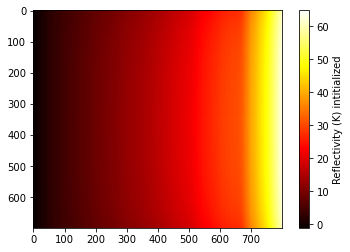

In [16]:
print("Imax max value: ", np.max(I_max0))
print("Imax min value: ", np.min(I_max0))
print("Reflectivity max value: ", np.max(K_reflec0))
print("Reflectivity min value: ", np.min(K_reflec0))
plt.imshow(K_reflec0, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Reflectivity (K) intitialized')

std =  0.03909546050345037


Text(0, 0.5, 'Finite difference debug')

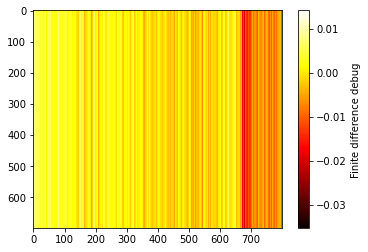

In [17]:
## Finite Differences

#from scipy.ndimage import gaussian_filter1d
#dZ3 = 100000*gaussian_filter1d(Z0,  axis=0, sigma=5, order=2, mode='wrap') #= np.gradient(Z, axis=1, )#edge_order=2

dx1 = np.diff(x_m, axis=1)
dx1[dx1 == 0] = np.nan
print("std = ",  np.nanstd(dx1))
dx1[dx1 < (np.nanmean(dx1) - np.nanstd(dx1))] = np.nanmean(dx1) - np.nanstd(dx1)
dx1[:,:] = np.nanmean(dx1)
dy1 = np.diff(y_m, axis=0)
dZ_dx_1 = np.divide(np.diff(Z0, axis=1), dx1)
dZ_dy_1 = np.divide(np.diff(Z0, axis=0),dy1)

dx2 = np.gradient(x_m, axis=1)
dx2[dx2 < 0.2] = 0.2
dy2 = np.gradient(y_m, axis=0)
dy2[dy2 < 0.25] = 0.25
dZ_dx_2 = np.divide(np.gradient(Z0, axis=1), dx2)
dZ_dy_2 = np.divide(np.gradient(Z0, axis=0), dy2)

plt.imshow(dZ_dx_1, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Finite difference debug')

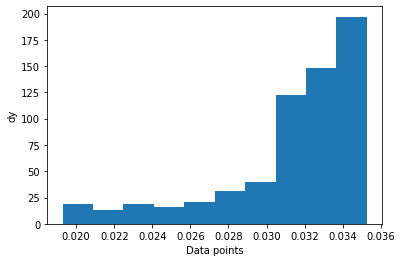

In [18]:
plt.hist(dy1[0,:], density=True, bins=10)  # density=False would make counts
plt.ylabel('dy')
plt.xlabel('Data points');
#x_m[0,:]

Text(0, 0.5, 'Finite difference debug')

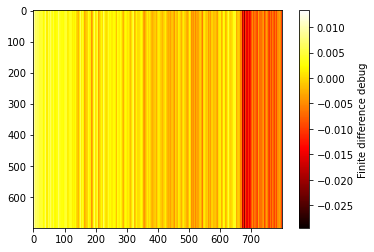

In [19]:
plt.imshow(np.gradient(Z0, axis=1), cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Finite difference debug')

0 ,1 ,2 ,
Done
jj : 3
E:  1.4314305323272584e+55


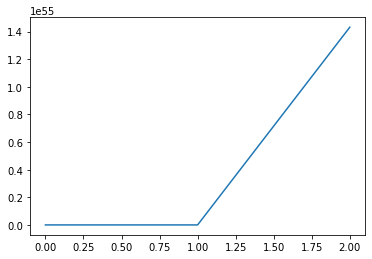

In [20]:
## Restart values
R = np.copy(R0)
Phi = np.copy(Phi0)        
Z = np.copy(Z0)

I_max = np.copy(I_max0)
K_reflec = np.copy(K_reflec0)

E_array = []
jj = 0
E = 1

dx1 = np.gradient(x_m, axis=1)
dx1[dx1 == 0] = np.nan
dx1[dx1 < (np.nanmean(dx1) - np.nanstd(dx1))] = np.nanmean(dx1) - np.nanstd(dx1)
dx1[:,:] = np.nanmean(dx1)

#if jj == 0:
    
# Optimization algorithm
while (E > 0.1 or jj < 3):
    ## Recompute y matrix
    y = np.divide(Z, np.tan(angles_rad))  #in meters
    y[0:350,:] = y[0:350]*(-1)
    
    ## Partial Derivatives by Finite Difference
    dy1 = np.gradient(y, axis=0)
    dZ_dx = np.divide(np.gradient(Z, axis=1), dx1)
    dZ_dy = np.divide(np.gradient(Z, axis=0),dy1)

    ## Error 
    I_hat = -K_reflec*Phi*R*np.divide(Z - x_m*dZ_dx, np.sqrt(x_m**2+Z**2)*np.sqrt(dZ_dx**2 + dZ_dy**2 + 1))
    E = np.sum((sss_intensity - I_hat)**2)
        
    ## Optimization (expectation maximization)
    R = R + 2*lambda_cons*I_hat*np.divide(sss_intensity - I_hat,R)
    Phi = Phi + 2*lambda_cons*I_hat*np.divide(sss_intensity - I_hat,Phi)
    Z = Z - 2*lambda_cons*I_hat*(sss_intensity - I_hat)*( np.divide(- dZ_dy - dZ_dx,1 + dZ_dy**2 + dZ_dx**2) + np.divide(1 + x_m, x_m*dZ_dx - Z) + np.divide(Z, x_m**2 + Z**2))
    
    # Regularization
    #for ii in np.arange(rows):
    #    Phi[ii, :] = np.median(Phi[ii, :])  # Phi(x,y)=Median{Phi(x0,y0)|alpha(x0,y0)=alpha(x,y)}
                          
    I_max = np.divide(-Z + np.divide(x_m**2*(1+dy1*Z)**2,-Z), np.sqrt(x_m**2+Z**2)*(1+(dy1*Z)**2 + np.divide(x_m**2*(1+(dy1*Z)**2),-Z**2)))
    K_reflec = np.divide(1, I_max)    
    
    E_array.append(E)
    print(jj, ",", end = '')
    jj += 1
    
    if jj == 3:
        print("\nDone")
        break
    
print("jj :", jj)
print("E: ", E)

plt.plot(np.arange(jj), E_array[0:jj])

Text(0, 0.5, 'debug')

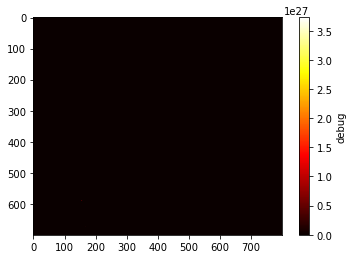

In [21]:
temp = I_hat
plt.imshow(temp, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel('debug')

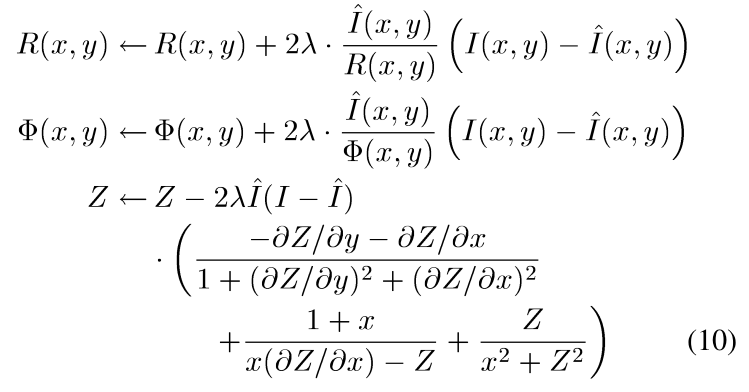

Median -0.010249076892671585


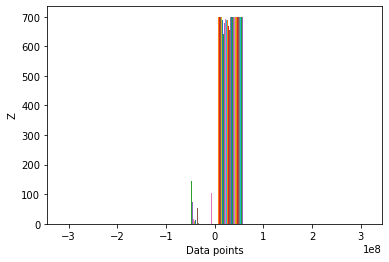

In [22]:
temp = dZ_dx
plt.hist(temp, bins=10)  # density=False would make counts
plt.ylabel('Z')
plt.xlabel('Data points');
print('Median', np.median(temp))

value:  0.061950740311116734


Text(0, 0.5, 'debug')

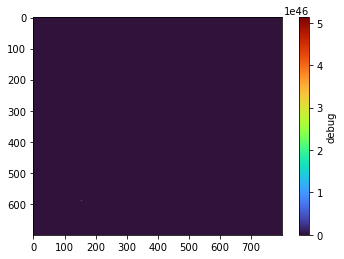

In [23]:
#Phi + 2*lambda_cons*I_hat*np.divide(sss_intensity-I_hat,Phi)
print("value: ",Phi[300,200])
plt.imshow(Phi, cmap='turbo')
cbar = plt.colorbar()
cbar.ax.set_ylabel('debug')

In [24]:
## Plot the point cloud
#plt.scatter(x,y,color=Z)

In [25]:
np.count_nonzero(~np.isnan(E_array))

3